# Multimodal RAG with ColQwen2, Reranker, and Quantized VLMs on Consumer GPUs

_Authored by: [Sergio Paniego](https://github.com/sergiopaniego)_





In this notebook, we demonstrate how to build a **Multimodal Retrieval-Augmented Generation (RAG)** system by combining the [**ColQwen2**](https://huggingface.co/vidore/colqwen2-v1.0) retriever for document retrieval with the [**Qwen2-VL**](https://qwenlm.github.io/blog/qwen2-vl/) Vision Language Model (VLM). Together, these models form a powerful RAG system capable of enhancing query responses with both text-based documents and visual data.

Instead of relying on a complex document processor pipeline that extracts data through OCR, we will leverage a Document Retrieval Model to efficiently retrieve the relevant documents based on a specific user query.

This notebook is an evolution of the previous [Multimodal Retrieval-Augmented Generation (RAG) with Document Retrieval (ColPali) and Vision Language Models (VLMs)](https://huggingface.co/learn/cookbook/multimodal_rag_using_document_retrieval_and_vlms). You may want to take a look at it before starting with this one!





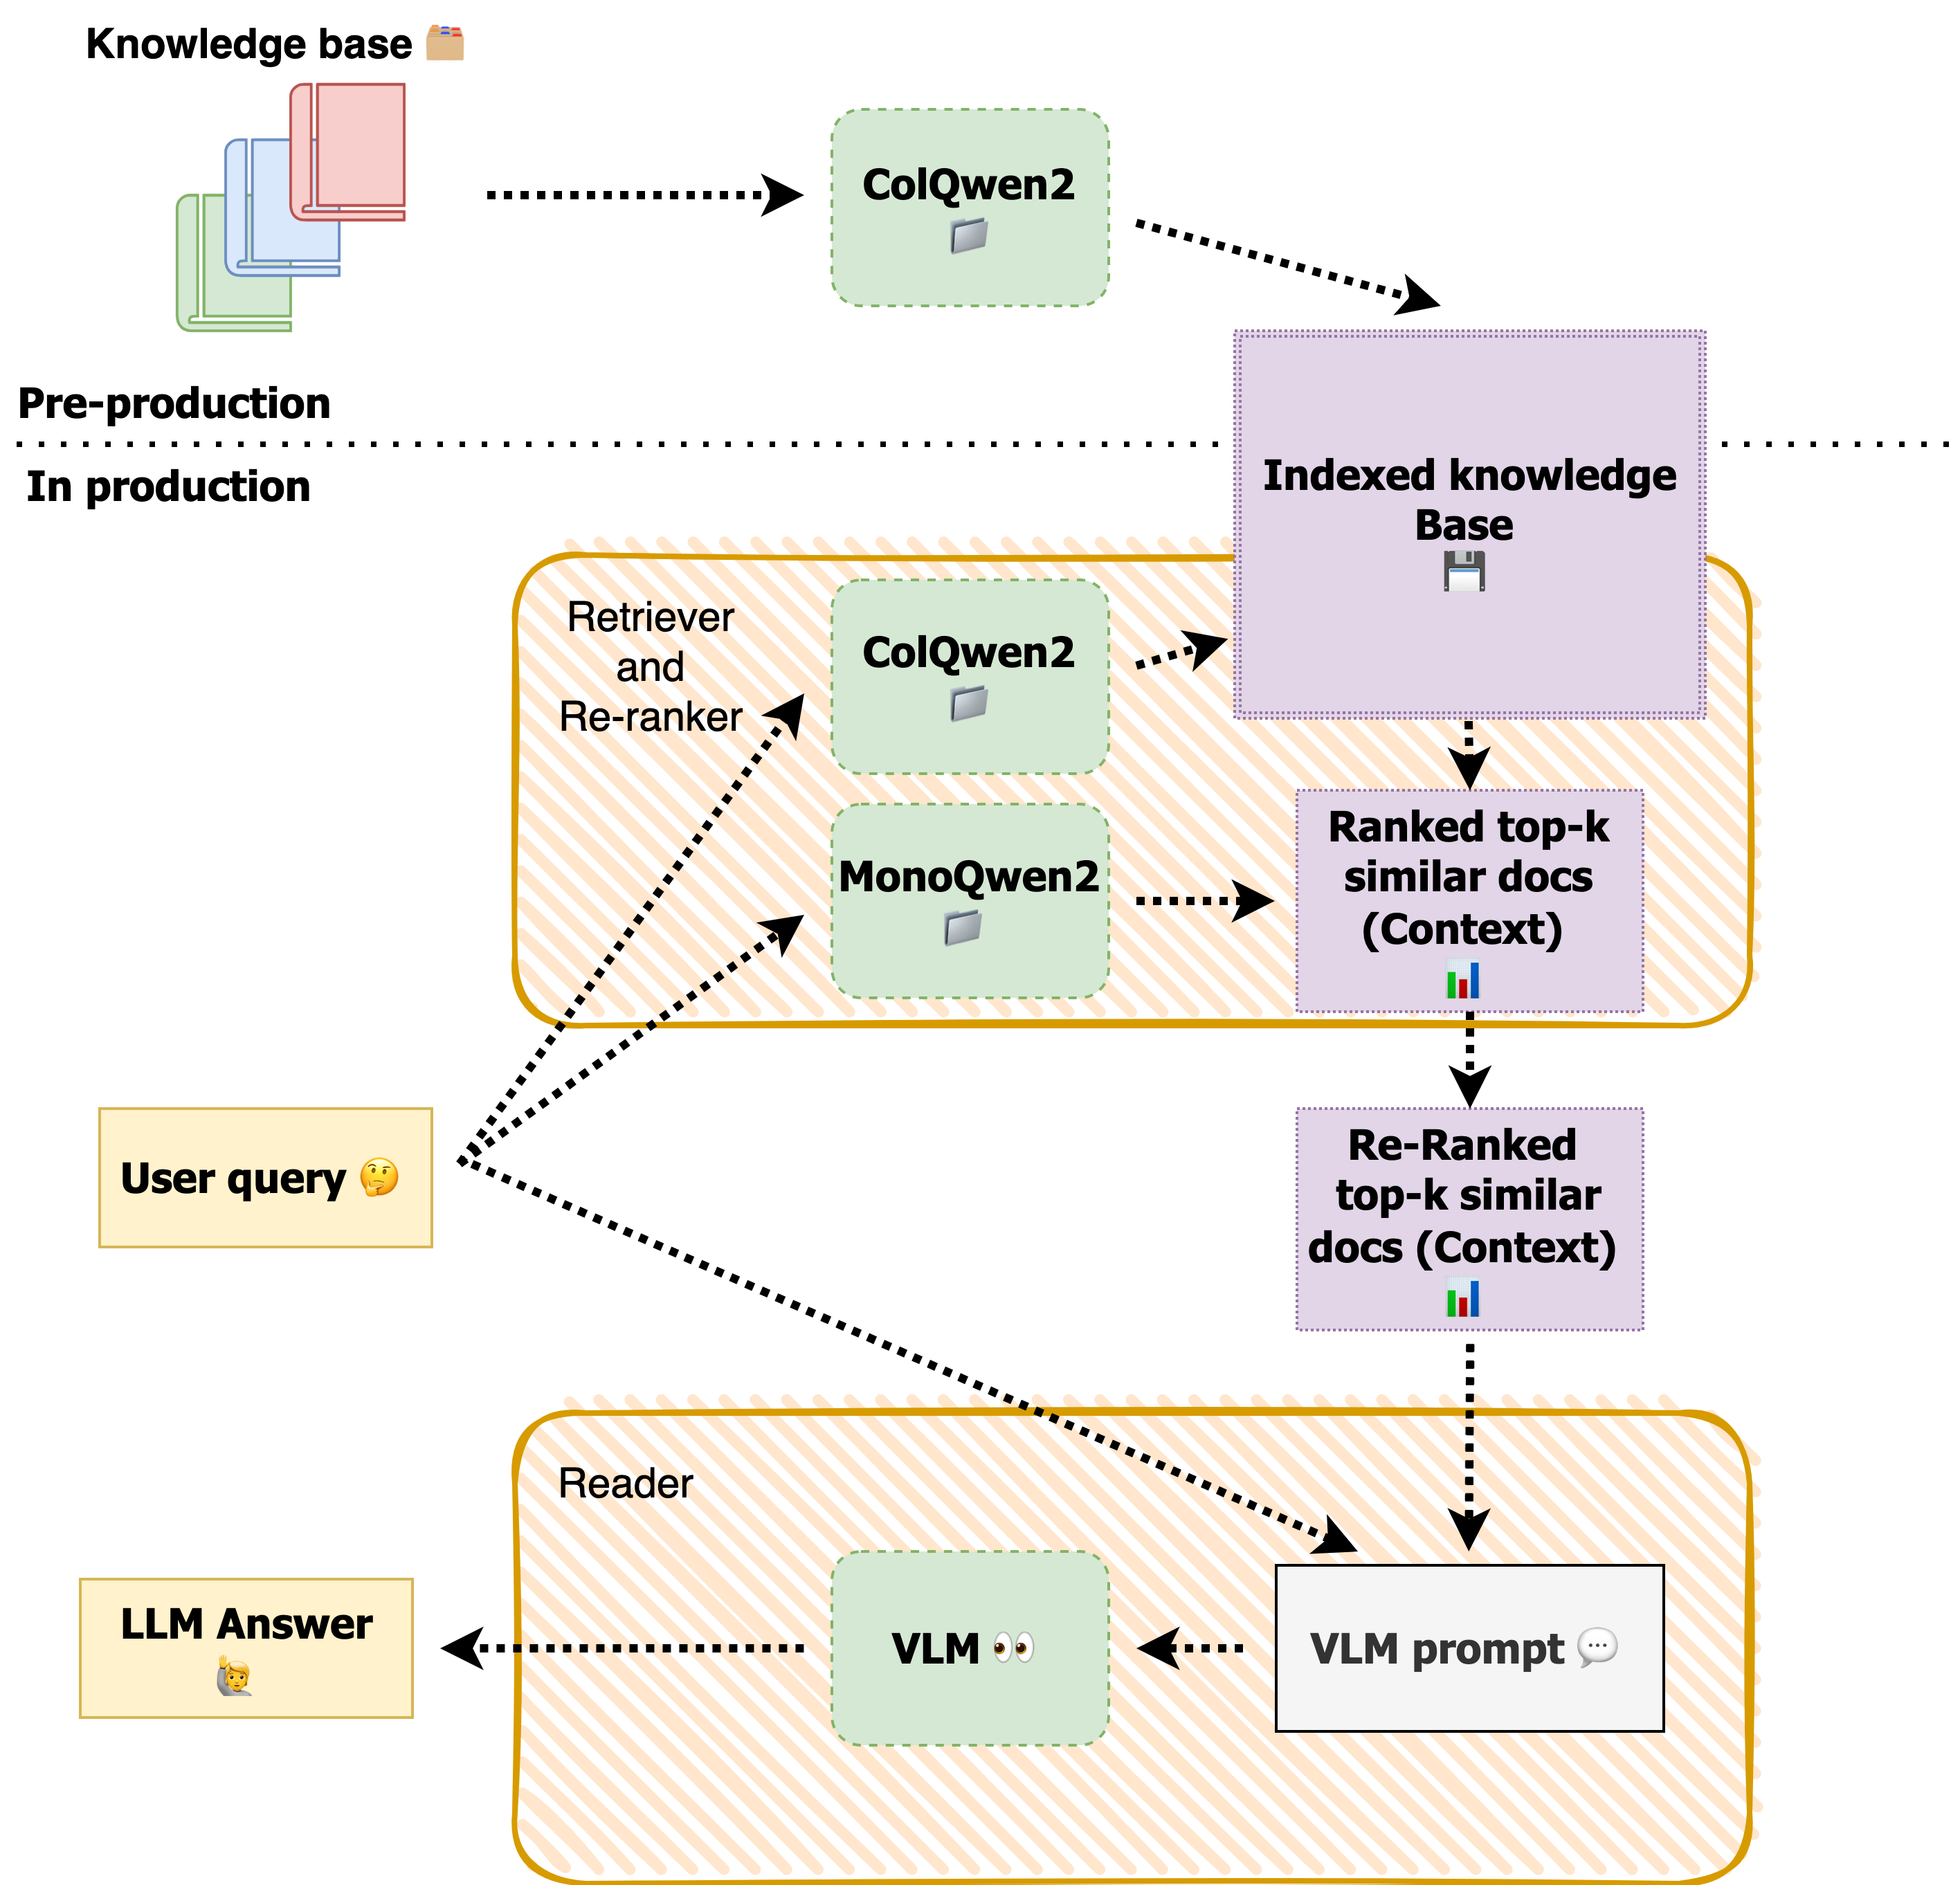

This diagram is inspired by [Aymeric Roucher's](https://huggingface.co/m-ric) work in the [Advanced RAG](https://huggingface.co/learn/cookbook/advanced_rag) or [RAG Evaluation](https://huggingface.co/learn/cookbook/rag_evaluation) recipes.


## 1. Install dependencies

Let’s kick off by installing the essential libraries for our project! 🚀



In [ ]:
!pip install -U -q byaldi pdf2image qwen-vl-utils transformers bitsandbytes peft
# Tested with byaldi==0.0.4, pdf2image==1.17.0, qwen-vl-utils==0.0.8, transformers==4.45.0

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 517.9/517.9 kB 35.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.4/122.4 MB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.7/44.7 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.6/251.6 kB 20.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 103.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.1/33.1 MB 60.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.2/307.2 kB 21.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 32.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 287.4/287.4 kB 21.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.0 MB/s eta 0:0

In [ ]:
!pip install -U -q rerankers[monovlm]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 82.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 320.7/320.7 kB 1.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.1/41.1 kB 3.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
colpali-engine 0.3.4 requires peft<0.12.0,>=0.11.0, but you have peft 0.13.2 which is incompatible.


We will also install **poppler-utils** to facilitate PDF manipulation. This utility provides essential tools for working with PDF files, ensuring we can efficiently handle any document-related tasks in our project.


In [ ]:
!sudo apt-get install -y poppler-utils

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  poppler-utils
0 upgraded, 1 newly installed, 0 to remove and 49 not upgraded.
Need to get 186 kB of archives.
After this operation, 696 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 poppler-utils amd64 22.02.0-2ubuntu0.5 [186 kB]
Fetched 186 kB in 1s (143 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package poppler-utils.
(Reading database ... 123629 

## 2. Load Dataset 📁

In this section, we will utilize IKEA assembly instructions as our dataset. These PDFs contain step-by-step guidance for assembling various furniture pieces. Imagine being able to ask our assistant for help while assembling your new IKEA furniture! 🛋

To download the assembly instructions, you can follow [these steps](https://www.ikea.com/us/en/customer-service/assembly-instructions-puba2cdc880).

For this notebook, I've selected a few examples, but in a real-world scenario, we could work with a large collection of PDFs to enhance our model’s capabilities.


In [ ]:
import requests
import os

pdfs = {
    "MALM": "https://www.ikea.com/us/en/assembly_instructions/malm-4-drawer-chest-white__AA-2398381-2-100.pdf",
    "BILLY": "https://www.ikea.com/us/en/assembly_instructions/billy-bookcase-white__AA-1844854-6-2.pdf",
    "BOAXEL": "https://www.ikea.com/us/en/assembly_instructions/boaxel-wall-upright-white__AA-2341341-2-100.pdf",
    "ADILS": "https://www.ikea.com/us/en/assembly_instructions/adils-leg-white__AA-844478-6-2.pdf",
    "MICKE": "https://www.ikea.com/us/en/assembly_instructions/micke-desk-white__AA-476626-10-100.pdf"
}

output_dir = "data"
os.makedirs(output_dir, exist_ok=True)

for name, url in pdfs.items():
    response = requests.get(url)
    pdf_path = os.path.join(output_dir, f"{name}.pdf")

    with open(pdf_path, "wb") as f:
        f.write(response.content)

    print(f"Downloaded {name} to {pdf_path}")

print("Downloaded files:", os.listdir(output_dir))

Downloaded MALM to data/MALM.pdf
Downloaded BILLY to data/BILLY.pdf
Downloaded BOAXEL to data/BOAXEL.pdf
Downloaded ADILS to data/ADILS.pdf
Downloaded MICKE to data/MICKE.pdf
Downloaded files: ['MICKE.pdf', 'BILLY.pdf', 'BOAXEL.pdf', 'MALM.pdf', 'ADILS.pdf']


After downloading the assembly instructions, we will convert the PDFs into images. This step is crucial, as it allows the document retrieval model (ColQwen2) to process and manipulate the visual content effectively.


In [ ]:
import os
from pdf2image import convert_from_path


def convert_pdfs_to_images(pdf_folder):
    pdf_files = [f for f in os.listdir(pdf_folder) if f.endswith('.pdf')]
    all_images = {}

    for doc_id, pdf_file in enumerate(pdf_files):
        pdf_path = os.path.join(pdf_folder, pdf_file)
        images = convert_from_path(pdf_path)
        all_images[doc_id] = images

    return all_images

all_images = convert_pdfs_to_images("/content/data/")

Let’s visualize a sample assembly guide to get a sense of how these instructions are presented! This will help us understand the format and layout of the content we’ll be working with. 👀


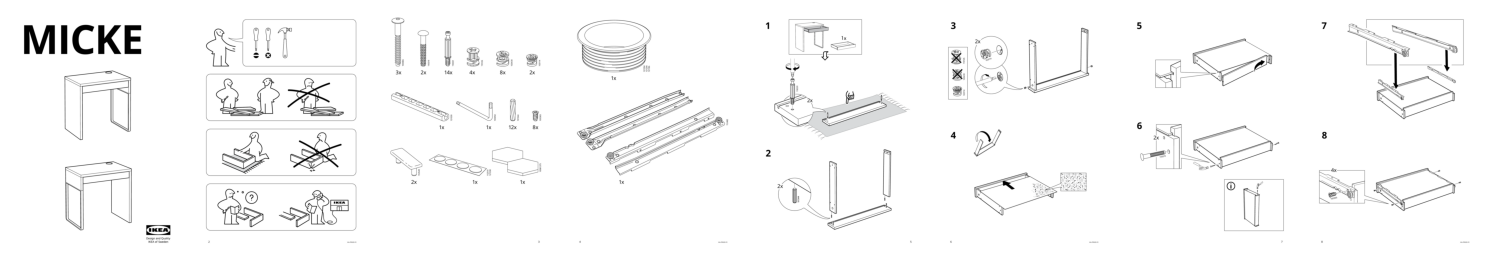

In [ ]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 8, figsize=(15, 10))

for i, ax in enumerate(axes.flat):
    img = all_images[0][i]
    ax.imshow(img)
    ax.axis('off')

plt.tight_layout()
plt.show()

## 3. Initialize the ColQwen2 Multimodal Document Retrieval Model 🤖


Now that our dataset is ready, we will initialize the Document Retrieval Model, which will be responsible for extracting relevant information from the raw images and providing us with the appropriate documents based on our queries.

By utilizing this model, we can significantly enhance our conversational capabilities.

For this task, we will use **[Byaldi](https://github.com/AnswerDotAI/byaldi)**. The developers describe the library as follows: _"Byaldi is RAGatouille's mini sister project. It is a simple wrapper around the ColPali repository to make it easy to use late-interaction multi-modal models such as ColPALI with a familiar API."_

In this project, we will specifically focus on **ColQwen2**.

![ColPali architecture](https://github.com/illuin-tech/colpali/blob/main/assets/colpali_architecture.webp?raw=true)

Additionally, you can explore **[ViDore (The Visual Document Retrieval Benchmark)](https://huggingface.co/spaces/vidore/vidore-leaderboard)** to see the top-performing retrievers in action.


First, we will load the model from the checkpoint.


In [ ]:
from byaldi import RAGMultiModalModel

docs_retrieval_model = RAGMultiModalModel.from_pretrained("vidore/colqwen2-v1.0")

Verbosity is set to 1 (active). Pass verbose=0 to make quieter.


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


adapter_config.json:   0%|          | 0.00/728 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.17k [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/56.5k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.85G [00:00<?, ?B/s]

`Qwen2VLRotaryEmbedding` can now be fully parameterized by passing the model config through the `config` argument. All other arguments will be removed in v4.46


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/220 [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/74.0M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/568 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/4.30k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/392 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/613 [00:00<?, ?B/s]

chat_template.json:   0%|          | 0.00/1.05k [00:00<?, ?B/s]

Next, we can directly index our documents using the document retrieval model by specifying the folder where the PDFs are stored. This will allow the model to process and organize the documents for efficient retrieval based on our queries.


In [ ]:
docs_retrieval_model.index(
    input_path="data/",
    index_name="image_index",
    store_collection_with_index=False,
    overwrite=True
)

Indexing file: data/MICKE.pdf
Added page 1 of document 0 to index.
Added page 2 of document 0 to index.
Added page 3 of document 0 to index.
Added page 4 of document 0 to index.
Added page 5 of document 0 to index.
Added page 6 of document 0 to index.
Added page 7 of document 0 to index.
Added page 8 of document 0 to index.
Added page 9 of document 0 to index.
Added page 10 of document 0 to index.
Added page 11 of document 0 to index.
Added page 12 of document 0 to index.
Added page 13 of document 0 to index.
Added page 14 of document 0 to index.
Added page 15 of document 0 to index.
Added page 16 of document 0 to index.
Added page 17 of document 0 to index.
Added page 18 of document 0 to index.
Added page 19 of document 0 to index.
Added page 20 of document 0 to index.
Added page 21 of document 0 to index.
Added page 22 of document 0 to index.
Added page 23 of document 0 to index.
Added page 24 of document 0 to index.
Index exported to .byaldi/image_index
Indexing file: data/BILLY.pdf

{0: 'data/MICKE.pdf',
 1: 'data/BILLY.pdf',
 2: 'data/BOAXEL.pdf',
 3: 'data/MALM.pdf',
 4: 'data/ADILS.pdf'}

## 4. Retrieving Documents with the Document Retrieval Model and Re-ranking with the Reranker 🤔

Having initialized the document retrieval model, we can now test its capabilities by submitting a user query and examining the relevant documents it retrieves.

The model will return the results, ranked directly by their relevance to the query.

Let’s give it a try!

In [ ]:
text_query = "How many people are needed to assemble the Malm?"

results = docs_retrieval_model.search(text_query, k=5)
results

[{'doc_id': 3, 'page_num': 1, 'score': 16.0, 'metadata': {}, 'base64': None},
 {'doc_id': 3, 'page_num': 27, 'score': 13.25, 'metadata': {}, 'base64': None},
 {'doc_id': 3, 'page_num': 25, 'score': 12.5625, 'metadata': {}, 'base64': None},
 {'doc_id': 0, 'page_num': 16, 'score': 11.625, 'metadata': {}, 'base64': None},
 {'doc_id': 3, 'page_num': 26, 'score': 11.4375, 'metadata': {}, 'base64': None}]

Now, let’s examine the specific documents (images) that the model has retrieved. This will allow us to see the visual content that corresponds to our query and understand how the model selects relevant information.


In [ ]:
def get_grouped_images(results, all_images):
    grouped_images = []

    for result in results:
        doc_id = result['doc_id']
        page_num = result['page_num']
        grouped_images.append(all_images[doc_id][page_num - 1]) # page_num are 1-indexed, while doc_ids are 0-indexed. Source https://github.com/AnswerDotAI/byaldi?tab=readme-ov-file#searching

    return grouped_images

grouped_images = get_grouped_images(results, all_images)

Let’s take a closer look at the retrieved documents to understand the information they contain. This examination will help us evaluate the relevance and quality of the retrieved content in relation to our query.


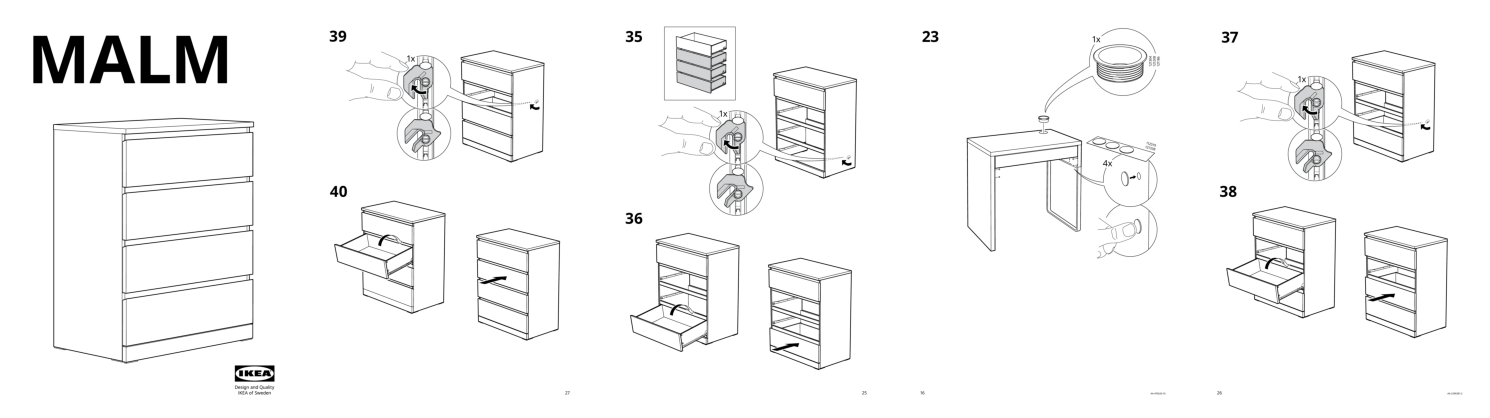

In [ ]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 5, figsize=(15, 10))

for i, ax in enumerate(axes.flat):
    img = grouped_images[i]
    ax.imshow(img)
    ax.axis('off')

plt.tight_layout()
plt.show()

Let's initialize our reranker model. For it, we will use the [rerankers](https://github.com/AnswerDotAI/rerankers) module.

In [ ]:
from rerankers import Reranker

ranker = Reranker("monovlm", device='cuda')

Loading default monovlm model for language en
Default Model: lightonai/MonoQwen2-VL-v0.1
Loading MonoVLMRanker model lightonai/MonoQwen2-VL-v0.1 (this message can be suppressed by setting verbose=0)
bf16
Using dtype torch.bfloat16
Loading model lightonai/MonoQwen2-VL-v0.1, this might take a while...
Using device cuda.
Using dtype torch.bfloat16.


preprocessor_config.json:   0%|          | 0.00/347 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/7.03M [00:00<?, ?B/s]

chat_template.json:   0%|          | 0.00/1.05k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.20k [00:00<?, ?B/s]

adapter_config.json:   0%|          | 0.00/721 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.20k [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/56.4k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/3.99G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/429M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/272 [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/148M [00:00<?, ?B/s]

VLM true token set to True
VLM false token set to False


In [ ]:
import base64
from io import BytesIO

def images_to_base64(images):
    base64_images = []
    for img in images:
        buffer = BytesIO()
        img.save(buffer, format="JPEG")
        buffer.seek(0)

        img_base64 = base64.b64encode(buffer.getvalue()).decode("utf-8")
        base64_images.append(img_base64)

    return base64_images

base64_list = images_to_base64(grouped_images)

Again, we pass the `text_query` and the list of images so the reranker can improve the retrieved context. Instead of using the 5 previously retrieved documents, we will only return 3. If you look at the results, you can see how the model gives the majority of the importance to only one image, improving the ranking from the previous iteration.

In [ ]:
results = ranker.rank(text_query, base64_list)

In [ ]:
def process_ranker_results(results, grouped_images, top_k=3, log=False):
    new_grouped_images = []
    for i, doc in enumerate(results.top_k(top_k)):
        if log:
          print(f"Rank {i}:")
          print("Document ID:", doc.doc_id)
          print("Document Score:", doc.score)
          print("Document Base64:", doc.base64[:30] + '...')
          print("Document Path:", doc.image_path)
        new_grouped_images.append(grouped_images[doc.doc_id])
    return new_grouped_images
new_grouped_images = process_ranker_results(results, grouped_images, top_k=3, log=True)

Rank 0:
Document ID: 0
Document Score: 0.4375
Document Base64: /9j/4AAQSkZJRgABAQAAAQABAAD/2w...
Document Path: None
Rank 1:
Document ID: 1
Document Score: 0.0216064453125
Document Base64: /9j/4AAQSkZJRgABAQAAAQABAAD/2w...
Document Path: None
Rank 2:
Document ID: 3
Document Score: 0.00885009765625
Document Base64: /9j/4AAQSkZJRgABAQAAAQABAAD/2w...
Document Path: None


After that, we are ready to load the VLM and answer the user query!

## 5. Initialize the Visual Language Model for Question Answering 🙋

Next, we will initialize the Visual Language Model (VLM) that we will use for question answering. In this case, we’ll be utilizing **[Qwen2_VL](https://huggingface.co/docs/transformers/main/en/model_doc/qwen2_vl)**.

![Qwen2_VL architecture](https://qianwen-res.oss-accelerate-overseas.aliyuncs.com/Qwen2-VL/qwen2_vl.jpg)

You can check the leaderboard for Open VLM to stay updated on the latest advancements [here](https://huggingface.co/spaces/opencompass/open_vlm_leaderboard).

First, we will load the model from the pretrained checkpoint and move it to the GPU for optimal performance. See the model [here](https://huggingface.co/Qwen/Qwen2-VL-7B-Instruct).


In [ ]:
from transformers import Qwen2VLForConditionalGeneration, Qwen2VLProcessor, BitsAndBytesConfig
from qwen_vl_utils import process_vision_info
import torch

# BitsAndBytesConfig int-4 config
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

# Load model and tokenizer
vl_model = Qwen2VLForConditionalGeneration.from_pretrained(
    "Qwen/Qwen2-VL-7B-Instruct",
    device_map="auto",
    torch_dtype=torch.bfloat16,
    quantization_config=bnb_config
)
vl_model.eval()

config.json:   0%|          | 0.00/1.20k [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/56.5k [00:00<?, ?B/s]

model-00001-of-00005.safetensors:   0%|          | 0.00/3.90G [00:00<?, ?B/s]

model-00002-of-00005.safetensors:   0%|          | 0.00/3.86G [00:00<?, ?B/s]

model-00003-of-00005.safetensors:   0%|          | 0.00/3.86G [00:00<?, ?B/s]

model-00004-of-00005.safetensors:   0%|          | 0.00/3.86G [00:00<?, ?B/s]

model-00005-of-00005.safetensors:   0%|          | 0.00/1.09G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/244 [00:00<?, ?B/s]

Qwen2VLForConditionalGeneration(
  (visual): Qwen2VisionTransformerPretrainedModel(
    (patch_embed): PatchEmbed(
      (proj): Conv3d(3, 1280, kernel_size=(2, 14, 14), stride=(2, 14, 14), bias=False)
    )
    (rotary_pos_emb): VisionRotaryEmbedding()
    (blocks): ModuleList(
      (0-31): 32 x Qwen2VLVisionBlock(
        (norm1): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (norm2): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (attn): VisionSdpaAttention(
          (qkv): Linear4bit(in_features=1280, out_features=3840, bias=True)
          (proj): Linear4bit(in_features=1280, out_features=1280, bias=True)
        )
        (mlp): VisionMlp(
          (fc1): Linear4bit(in_features=1280, out_features=5120, bias=True)
          (act): QuickGELUActivation()
          (fc2): Linear4bit(in_features=5120, out_features=1280, bias=True)
        )
      )
    )
    (merger): PatchMerger(
      (ln_q): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)


Next, we will initialize the VLM processor. In this step, we specify the minimum and maximum pixel sizes to optimize the fitting of more images into the GPU memory.

For further details on optimizing image resolution for performance, you can refer to the documentation [here](https://huggingface.co/docs/transformers/main/en/model_doc/qwen2_vl#image-resolution-for-performance-boost).


In [ ]:
min_pixels = 224*224
max_pixels = 448*448
vl_model_processor = Qwen2VLProcessor.from_pretrained(
    "Qwen/Qwen2-VL-7B-Instruct",
    min_pixels=min_pixels,
    max_pixels=max_pixels
)

preprocessor_config.json:   0%|          | 0.00/347 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/7.03M [00:00<?, ?B/s]

chat_template.json:   0%|          | 0.00/1.05k [00:00<?, ?B/s]

## 6. Assembling the VLM Model and Testing the System 🔧

With all components loaded, we can now assemble the system for testing. First, we will create the chat structure by providing the system with the three retrieved images along with the user query. This step can be customized to fit your specific needs, allowing for greater flexibility in how you interact with the model!

In [ ]:
chat_template = [
    {
        "role": "user",
        "content": [
            {
                "type": "image",
                "image": new_grouped_images[0],
            },
            {
                "type": "image",
                "image": new_grouped_images[1],
            },
            {
                "type": "image",
                "image": new_grouped_images[2],
            },
            {
                "type": "text",
                "text": text_query
            },
        ],
    }
]


Now, let's apply this chat structure.


In [ ]:
text = vl_model_processor.apply_chat_template(
    chat_template, tokenize=False, add_generation_prompt=True
)

Next, we will process the inputs to ensure they are properly formatted and ready to be used as input for the Visual Language Model (VLM). This step is essential for enabling the model to effectively generate responses based on the provided data.

In [ ]:
image_inputs, _ = process_vision_info(chat_template)
inputs = vl_model_processor(
    text=[text],
    images=image_inputs,
    padding=True,
    return_tensors="pt",
)
inputs = inputs.to("cuda")

We are now ready to generate the answer! Let’s see how the system utilizes the processed inputs to provide a response based on the user query and the retrieved images.


In [ ]:
generated_ids = vl_model.generate(**inputs, max_new_tokens=500)

Once the model has generated the output, we postprocess it to generate the final answer.

In [ ]:
generated_ids_trimmed = [
    out_ids[len(in_ids) :] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
]
output_text = vl_model_processor.batch_decode(
    generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
)

In [ ]:
print(output_text[0])

The image shows that two people are needed to assemble the Malm.


## 7. Assembling It All! 🧑‍🏭️

Now, let’s create a method that encompasses the entire pipeline, allowing us to easily reuse it in future applications.


In [ ]:
def answer_with_multimodal_rag(vl_model, docs_retrieval_model, vl_model_processor, grouped_images, text_query, retrival_top_k, reranker_top_k, max_new_tokens):
    results = docs_retrieval_model.search(text_query, k=retrival_top_k)
    grouped_images = get_grouped_images(results, all_images)

    base64_list = images_to_base64(grouped_images)
    results = ranker.rank(text_query, base64_list)
    grouped_images = process_ranker_results(results, grouped_images, top_k=reranker_top_k)

    chat_template = [
    {
      "role": "user",
      "content": [
          {"type": "image", "image": image} for image in grouped_images
            ] + [
          {"type": "text", "text": text_query}
        ],
      }
    ]

    # Prepare the inputs
    text = vl_model_processor.apply_chat_template(chat_template, tokenize=False, add_generation_prompt=True)
    image_inputs, video_inputs = process_vision_info(chat_template)
    inputs = vl_model_processor(
        text=[text],
        images=image_inputs,
        padding=True,
        return_tensors="pt",
    )
    inputs = inputs.to("cuda")

    # Generate text from the vl_model
    generated_ids = vl_model.generate(**inputs, max_new_tokens=max_new_tokens)
    generated_ids_trimmed = [
        out_ids[len(in_ids):] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
    ]

    # Decode the generated text
    output_text = vl_model_processor.batch_decode(
        generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
    )

    return output_text

Let’s take a look at how the complete RAG system operates!


In [ ]:
output_text = answer_with_multimodal_rag(
    vl_model=vl_model,
    docs_retrieval_model=docs_retrieval_model,
    vl_model_processor=vl_model_processor,
    grouped_images=grouped_images,
    text_query="How do I assemble the Micke desk?",
    retrival_top_k=3,
    reranker_top_k=3,
    max_new_tokens=500
)
print(output_text[0])

To assemble the Micke desk, follow these steps:

1. **Prepare the Components**: Lay out all the components of the desk on a flat surface. This includes the desk top, legs, and any other parts that come with the desk.

2. **Attach the Legs**: Place the legs on the bottom of the desk top. Make sure the legs are positioned correctly and are aligned with the holes in the desk top.

3. **Secure the Legs**: Use the included screws to secure the legs to the desk top. Make sure each leg is tightly secured to prevent wobbling.

4. **Attach the Back Panel**: If the desk comes with a back panel, attach it to the back of the desk top. This will provide additional support and stability.

5. **Check for Stability**: Once all the components are attached, check the desk for stability. Make sure it is level and does not wobble.

6. **Final Check**: Double-check that all screws are tightened and that there are no loose parts.

If you encounter any issues during the assembly process, refer to the instruc

In [ ]:
import torch
torch.cuda.empty_cache()
torch.cuda.synchronize()
print(f"GPU allocated memory: {torch.cuda.memory_allocated() / 1024**3:.2f} GB")
print(f"GPU reserved memory: {torch.cuda.memory_reserved() / 1024**3:.2f} GB")

GPU allocated memory: 13.93 GB
GPU reserved memory: 14.58 GB


🏆 We now have a fully operational RAG pipeline that leverages both a Document Retrieval Model and a Visual Language Model! This powerful combination enables us to generate insightful responses based on user queries and relevant documents.



## 8. Continuing the Journey 🧑‍🎓️

This recipe is just the starting point in exploring the potential of multimodal RAG systems. If you're eager to dive deeper, here are some ideas and resources to guide your next steps:

### 🔍 Explore Further with ColPali/ColQwen2:
- [Document Similarity Search with ColPali](https://huggingface.co/blog/fsommers/document-similarity-colpali)
- [ColPali Cookbooks 👀](https://github.com/tonywu71/colpali-cookbooks/tree/main)
- [ColPali Fine-Tuning Query Generator](https://huggingface.co/spaces/davanstrien/ColPali-Query-Generator)
- [Generating a Query Dataset for Fine-Tuning ColPali on a UFO Dataset](https://danielvanstrien.xyz/posts/post-with-code/colpali/2024-09-23-generate_colpali_dataset.html)

### 📖 Additional Reads:
- [Beyond Text: The Rise of Vision-Driven Document Retrieval for RAG](https://blog.vespa.ai/the-rise-of-vision-driven-document-retrieval-for-rag/)
- [Scaling ColPali to Billions of PDFs with Vespa](https://blog.vespa.ai/scaling-colpali-to-billions/)

### 💡 Useful Collections:
- [Multimodal RAG Collection](https://huggingface.co/collections/merve/multimodal-rag-66d97602e781122aae0a5139)

### 📝 The Paper and Original Code:
- [ColPali: Efficient Document Retrieval with Vision Language Models (Paper)](https://arxiv.org/pdf/2407.01449)
- [ColPali: Efficient Document Retrieval with Vision Language Models (Repo)](https://github.com/illuin-tech/colpali)

Feel free to explore these resources as you continue your journey into the world of multimodal retrieval and generation systems!

